In [1]:
from pathlib import Path
import pickle
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.insert(0, str(Path.cwd() / "Source"))
from BOGP import utils
from BOGP.optimization.optimizer import Optimizer, OptimizerConfig, Results
from BOGP.optimization.plotting import ResultsPlotter

ROOT = Path.cwd() / "Data" / "Simulations"
FIGUREPATH = Path.cwd() / "Reports" / "Figures"

In [2]:
def plot_performance_history(df, ax=None, label=None):
    if ax is None:
        ax = plt.gca()

    mean = df.mean(axis=0).values
    std = df.std(axis=0).values
    ucb = mean + std
    lcb = mean - std
    evals = df.columns.to_numpy()

    line, = ax.plot(evals, mean, label=label)
    ax.fill_between(evals, lcb, ucb, alpha=0.2)
    return line

## Simulations

We next demonstrate the performance characteristics of the Bayesian optimization method using simulations under a variety of configurations. Simulations are modeled after the SWELLEX96 underwater acoustics experiment conducted off the coast of Southern California. In the SWELLEX96 experiment, a vertical line array (VLA) of 64~hydrophones evenly spaced between depths of 94.125 and 212.5~m recorded multi-tonal transmissions from a towed acoustic source at a depth of 61~m.  The closest point of approach (CPA) of the source was . For this study, a single-frequency transmission is simulated at 201 Hz from a depth of 61~m.  In the following sections, range estimation, source localization, and geoacoustic inversion are demonstrated fo

### Range Estimation

In this scenario, we estimate the range to an acoustic source from an array.

In [3]:
EXPERIMENT = ROOT / "range_estimation"

evaluations = {
    "acq_func": ["ProbabilityOfImprovement", "ExpectedImprovement"],
    "snr": ["inf", "20"],
    "rec_r": ["0.5", "3.0", "6.0", "10.0"],
}
folders = utils.folders_of_evaluations(evaluations)

df = pd.read_csv(EXPERIMENT / "aggregated.csv", index_col=0)
df["best_param"] = df["best_param"].str.strip("[").str.strip("]").astype(float)

Performance history is shown for the range estimation optimization using each acquisition function for a combination of ranges and signal-to-noise ratios, with the best observed value plotted for each sequential evaluation of the objective function.  Solid lines indicate mean performance history for the 1000 Monte Carlo simulations, and the shaded regions indicate standard deviation.

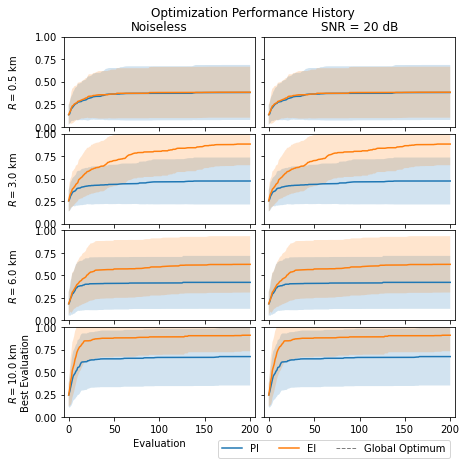

In [5]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.075, wspace=0.05)

for i, row in enumerate(evaluations["rec_r"]):
    for j, col in enumerate(evaluations["snr"]):
        ax = fig.add_subplot(gs[i, j])
        selection = (
            (df["acq_func"] == "ProbabilityOfImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        line0 = plot_performance_history(
            df[selection].pivot(index="seed", columns="evaluation", values="best_value"),
            label="PI"
        )
        selection = (
            (df["acq_func"] == "ExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        line1 = plot_performance_history(
            df[selection].pivot(index="seed", columns="evaluation", values="best_value"),
            label="EI"
        )
        optimum = ax.axhline(0, c="k", ls="--", lw=1, alpha=0.5)
        ax.set_xlim(-5, 205)
        ax.set_ylim(0, 1)
        
        if i == 0 and j == 0:
            ax.set_title("Noiseless")
        elif i == 0 and j == 1:
            ax.set_title(f"SNR = {col} dB")

        if i != 3:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])
        
        if j == 0:
            if i != 3:
                ax.set_ylabel(f"$R={float(row):.1f}$ km\n")
            elif i == 3:
                ax.set_xlabel("Evaluation")
                ax.set_ylabel(f"$R={float(row):.1f}$ km\nBest Evaluation")
        
        if i == 3 and j == 1:
            ax.legend([line0, line1, optimum], ["PI", "EI", "Global Optimum"], loc="right", ncol=3, bbox_to_anchor=(1, -0.35))

fig.suptitle("Optimization Performance History", y=0.94)
# fig.savefig(FIGUREPATH / "RangeEst_PerfHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()


Mean absolute error (MAE) for the 1000 Monte Carlo range estimation simulations is shown at each sequential evalution of the objective function.

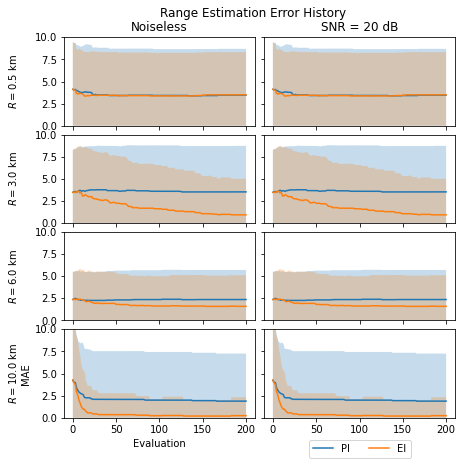

In [8]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.1, wspace=0.05)

for i, row in enumerate(evaluations["rec_r"]):
    for j, col in enumerate(evaluations["snr"]):
        ax = fig.add_subplot(gs[i, j])
        selection = (
            (df["acq_func"] == "ProbabilityOfImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        # df[selection].pivot(index="seed", columns="evaluation", values="best_param")
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param")

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2*std
        lcb[lcb < 0] = 0

        line0, = ax.plot(error.columns, mean, label="PI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        selection = (
            (df["acq_func"] == "ExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        # df[selection].pivot(index="seed", columns="evaluation", values="best_param")
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param")

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2-std
        lcb[lcb < 0] = 0

        line1, = ax.plot(error.columns, mean, label="EI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        # [ax.plot(abs(df_plot.iloc[i]-float(row)), "k", alpha=0.1) for i in range(len(df_plot))]
        ax.set_ylim(0, 10)

        if i == 0 and j == 0:
            ax.set_title("Noiseless")
        elif i == 0 and j == 1:
            ax.set_title(f"SNR = {col} dB")

        if i != 3:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])
        
        if j == 0:
            if i != 3:
                ax.set_ylabel(f"$R={float(row):.1f}$ km\n")
            elif i == 3:
                ax.set_xlabel("Evaluation")
                ax.set_ylabel(f"$R={float(row):.1f}$ km\nMAE [km]")
        
        if i == 3 and j == 1:
            ax.legend([line0, line1], ["PI", "EI"], loc="center", ncol=2, bbox_to_anchor=(0.5, -0.35))

fig.suptitle("Range Estimation Error History", y=0.94)
# fig.savefig(FIGUREPATH / "RangeEst_ErrHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

Drill down into one of the simulations to see how BOGP progresses.

In [4]:
DATA_FOLDER = EXPERIMENT / "acq_func=ExpectedImprovement__snr=20__rec_r=3.0" / "Runs" / "0063373286"
optim_config = torch.load(DATA_FOLDER / "optim.pth", map_location=torch.device("cpu"))
results = Results().load(DATA_FOLDER / "results.pth")

In [5]:
model_data = np.load(DATA_FOLDER.parent.parent / "measured" / "measured.npz")
K = model_data["covariance"]
p_rec = model_data["pressure"]
with open(DATA_FOLDER.parent.parent / "measured" / "parameters.pkl", "rb") as f:
    parameters = pickle.load(f)

In [6]:
optim_config["obj_func_kwargs"] = {
    "K": K,
    "parameters": parameters
}

In [7]:
search_parameters = [{"name": "x1", "bounds": [0.001, 10]}]
X_test = torch.linspace(
    search_parameters[0]["bounds"][0], search_parameters[0]["bounds"][1], 1001
).unsqueeze(1)

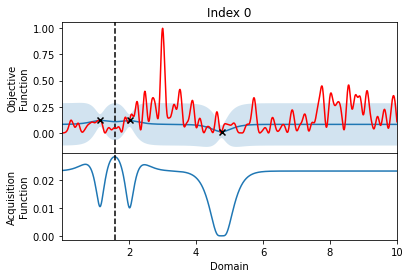

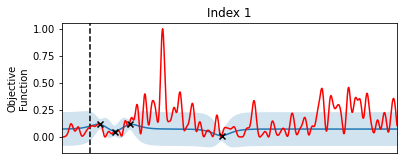

In [11]:
pltr = ResultsPlotter(optim_config, results)
parameters_to_plot = ["x1"]
pltr.plot_training_iterations(X_test, parameters_to_plot, index=[0, 1])

### Source Localization

In [3]:
EXPERIMENT = ROOT / "localization"

evaluations = {
    "acq_func": ["ProbabilityOfImprovement", "ExpectedImprovement", "qExpectedImprovement"],
    "snr": ["inf", "20"],
    "rec_r": ["0.5", "3.0", "6.0", "10.0"],
    "src_z": ["62"]
}
folders = utils.folders_of_evaluations(evaluations)

df = pd.read_csv(EXPERIMENT / "aggregated.csv", index_col=0)
new_cols = df["best_param"].str.strip("[ ").str.strip(" ]").str.split(" ", n=1, expand=True)
new_cols.columns = [f"best_param{col}" for col in new_cols.columns]
df = pd.concat([df, new_cols], axis=1).drop("best_param", axis=1)
df

FileNotFoundError: [Errno 2] No such file or directory: '/Users/williamjenkins/Research/Projects/BOGP/Data/Simulations/localization/aggregated.csv'

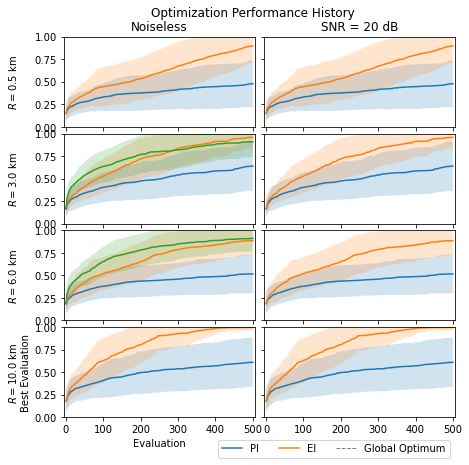

In [5]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.075, wspace=0.05)

for i, row in enumerate(evaluations["rec_r"]):
    for j, col in enumerate(evaluations["snr"]):
        ax = fig.add_subplot(gs[i, j])
        selection = (
            (df["acq_func"] == "ProbabilityOfImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        line0 = plot_performance_history(
            df[selection].pivot(index="seed", columns="evaluation", values="best_value"),
            label="PI"
        )
        selection = (
            (df["acq_func"] == "ExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        line1 = plot_performance_history(
            df[selection].pivot(index="seed", columns="evaluation", values="best_value"),
            label="EI"
        )
        selection = (
            (df["acq_func"] == "qExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        line2 = plot_performance_history(
            df[selection].pivot(index="seed", columns="evaluation", values="best_value"),
            label="qEI"
        )
        optimum = ax.axhline(0, c="k", ls="--", lw=1, alpha=0.5)
        ax.set_xlim(-5, 505)
        ax.set_ylim(0, 1)
        
        if i == 0 and j == 0:
            ax.set_title("Noiseless")
        elif i == 0 and j == 1:
            ax.set_title(f"SNR = {col} dB")

        if i != 3:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])
        
        if j == 0:
            if i != 3:
                ax.set_ylabel(f"$R={float(row):.1f}$ km\n")
            elif i == 3:
                ax.set_xlabel("Evaluation")
                ax.set_ylabel(f"$R={float(row):.1f}$ km\nBest Evaluation")
        
        if i == 3 and j == 1:
            ax.legend([line0, line1, optimum], ["PI", "EI", "Global Optimum"], loc="right", ncol=3, bbox_to_anchor=(1, -0.35))

fig.suptitle("Optimization Performance History", y=0.94)
# fig.savefig(FIGUREPATH / "Localization_PerfHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()


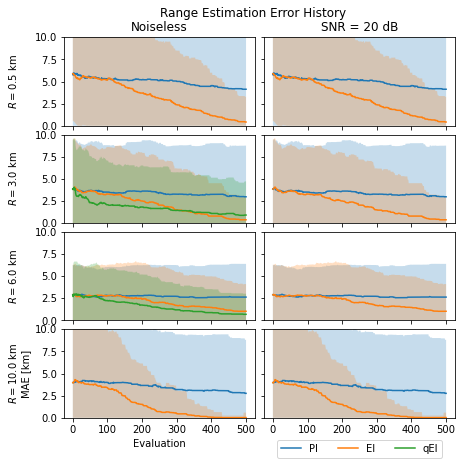

In [9]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.1, wspace=0.05)

for i, row in enumerate(evaluations["rec_r"]):
    for j, col in enumerate(evaluations["snr"]):
        ax = fig.add_subplot(gs[i, j])
        selection = (
            (df["acq_func"] == "ProbabilityOfImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        # df[selection].pivot(index="seed", columns="evaluation", values="best_param0")
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param0").astype(float)

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2*std
        lcb[lcb < 0] = 0

        line0, = ax.plot(error.columns, mean, label="PI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        selection = (
            (df["acq_func"] == "ExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        # df[selection].pivot(index="seed", columns="evaluation", values="best_param0")
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param0").astype(float)

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2-std
        lcb[lcb < 0] = 0

        line1, = ax.plot(error.columns, mean, label="EI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        selection = (
            (df["acq_func"] == "qExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        # df[selection].pivot(index="seed", columns="evaluation", values="best_param0")
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param0").astype(float)

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2-std
        lcb[lcb < 0] = 0

        line2, = ax.plot(error.columns, mean, label="qEI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        # [ax.plot(abs(df_plot.iloc[i]-float(row)), "k", alpha=0.1) for i in range(len(df_plot))]
        ax.set_ylim(0, 10)

        if i == 0 and j == 0:
            ax.set_title("Noiseless")
        elif i == 0 and j == 1:
            ax.set_title(f"SNR = {col} dB")

        if i != 3:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])
        
        if j == 0:
            if i != 3:
                ax.set_ylabel(f"$R={float(row):.1f}$ km\n")
            elif i == 3:
                ax.set_xlabel("Evaluation")
                ax.set_ylabel(f"$R={float(row):.1f}$ km\nMAE [km]")
        
        if i == 3 and j == 1:
            ax.legend([line0, line1, line2], ["PI", "EI", "qEI"], loc="center", ncol=3, bbox_to_anchor=(0.5, -0.35))

fig.suptitle("Range Estimation Error History", y=0.94)
# fig.savefig(FIGUREPATH / "Localization_ErrHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

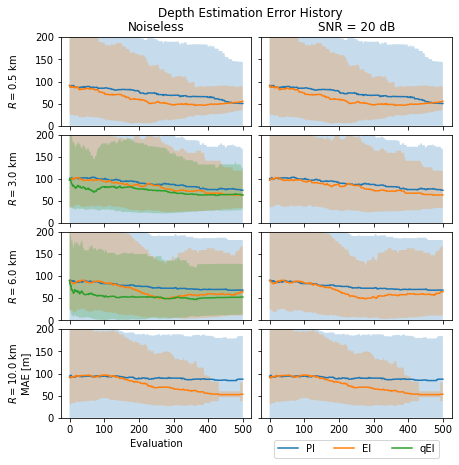

In [10]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.1, wspace=0.05)

for i, row in enumerate(evaluations["rec_r"]):
    for j, col in enumerate(evaluations["snr"]):
        ax = fig.add_subplot(gs[i, j])
        selection = (
            (df["acq_func"] == "ProbabilityOfImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param1").astype(float)

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2*std
        lcb[lcb < 0] = 0

        line0, = ax.plot(error.columns, mean, label="PI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        selection = (
            (df["acq_func"] == "ExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param1").astype(float)

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2-std
        lcb[lcb < 0] = 0

        line1, = ax.plot(error.columns, mean, label="EI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        selection = (
            (df["acq_func"] == "qExpectedImprovement")
            & (df["snr"] == float(col))
            & (df["rec_r"] == float(row))
        )
        df_plot = df[selection].pivot(index="seed", columns="evaluation", values="best_param1").astype(float)

        error = abs(df_plot - float(row))
        mean = error.mean(axis=0).values
        std = error.std(axis=0).values
        ucb = mean + 2*std
        lcb = mean - 2-std
        lcb[lcb < 0] = 0

        line2, = ax.plot(error.columns, mean, label="qEI")
        ax.fill_between(error.columns, lcb, ucb, alpha=0.25)


        # [ax.plot(abs(df_plot.iloc[i]-float(row)), "k", alpha=0.1) for i in range(len(df_plot))]
        ax.set_ylim(0, 200)

        if i == 0 and j == 0:
            ax.set_title("Noiseless")
        elif i == 0 and j == 1:
            ax.set_title(f"SNR = {col} dB")

        if i != 3:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])
        
        if j == 0:
            if i != 3:
                ax.set_ylabel(f"$R={float(row):.1f}$ km\n")
            elif i == 3:
                ax.set_xlabel("Evaluation")
                ax.set_ylabel(f"$R={float(row):.1f}$ km\nMAE [m]")
        
        if i == 3 and j == 1:
            ax.legend([line0, line1, line2], ["PI", "EI", "qEI"], loc="center", ncol=3, bbox_to_anchor=(0.5, -0.35))

fig.suptitle("Depth Estimation Error History", y=0.94)
# fig.savefig(FIGUREPATH / "Localization_ErrHist.png", dpi=200, facecolor="white", bbox_inches="tight")
plt.show()

In [11]:
DATA_FOLDER = EXPERIMENT / "acq_func=qExpectedImprovement__snr=inf__rec_r=3.0__src_z=62" / "Runs" / "0075533339"
optim_config = torch.load(DATA_FOLDER / "optim.pth", map_location=torch.device("cpu"))
results = Results().load(DATA_FOLDER / "results.pth")

In [12]:
model_data = np.load(DATA_FOLDER.parent.parent / "measured" / "measured.npz")
K = model_data["covariance"]
p_rec = model_data["pressure"]
with open(DATA_FOLDER.parent.parent / "measured" / "parameters.pkl", "rb") as f:
    parameters = pickle.load(f)

In [13]:
optim_config["obj_func_kwargs"] = {
    "K": K,
    "parameters": parameters
}

In [14]:
search_parameters = [
    {"name": "rec_r", "bounds": [0.001, 10]},
    {"name": "src_z", "bounds": [0, 200]}
]

X_test = torch.cartesian_prod(
    torch.linspace(
        search_parameters[0]["bounds"][0], search_parameters[0]["bounds"][1], 101
    ),
    torch.linspace(
        search_parameters[1]["bounds"][0], search_parameters[1]["bounds"][1], 101
    )
).unsqueeze(1)

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


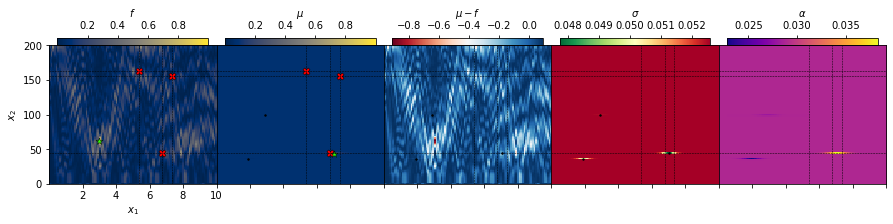

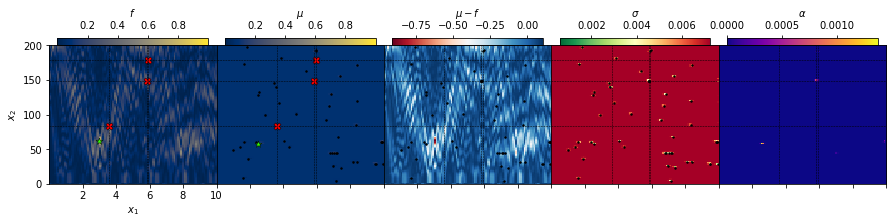

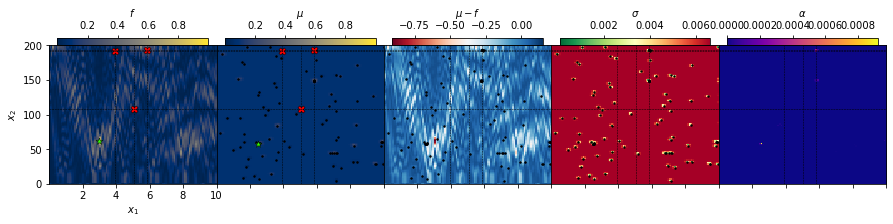

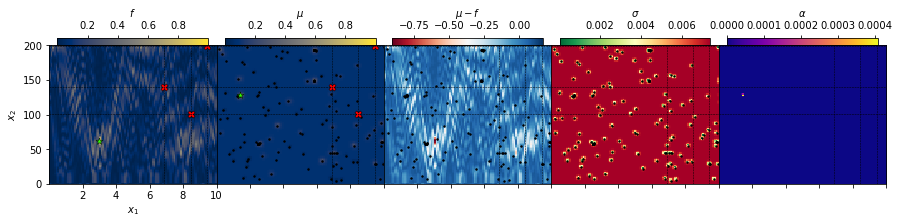

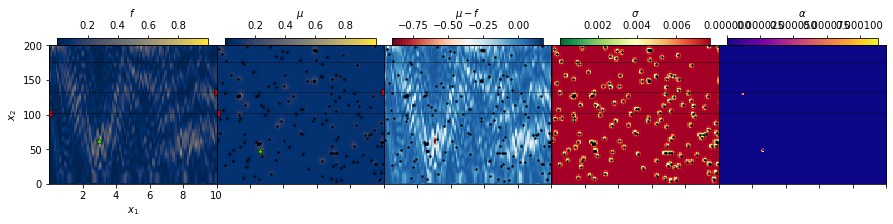

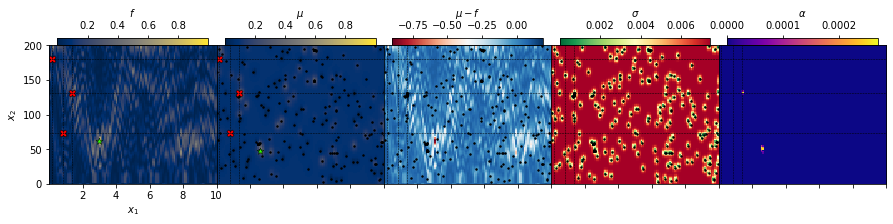

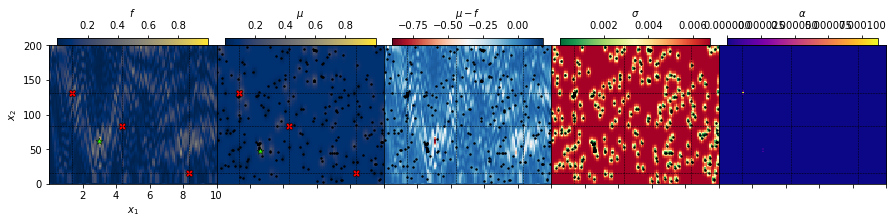

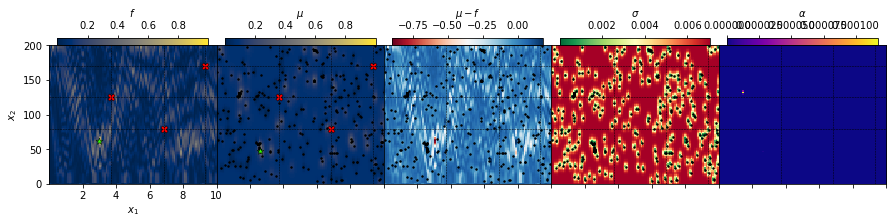

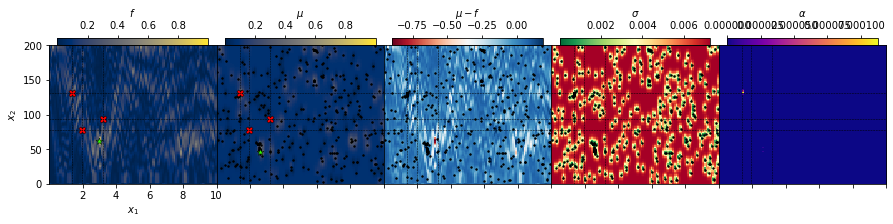

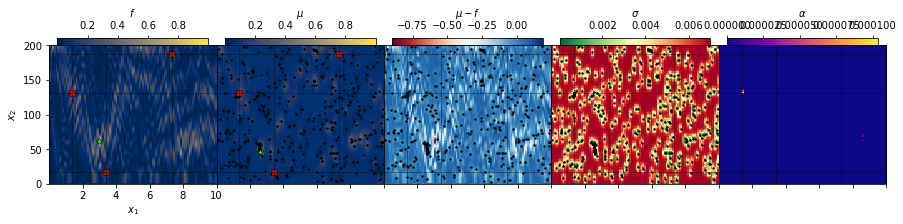

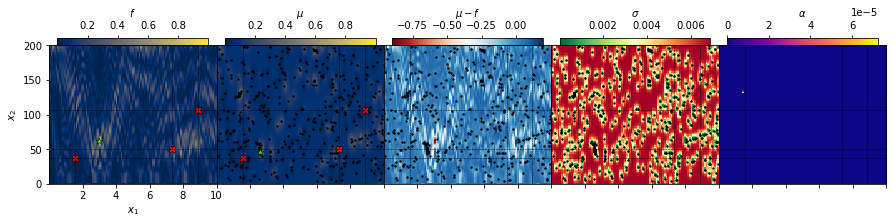

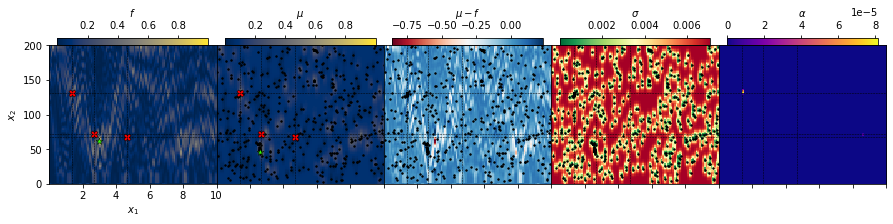

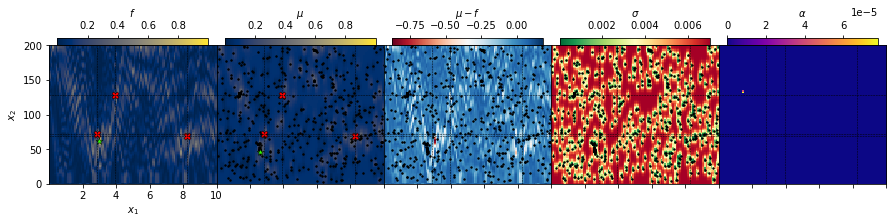

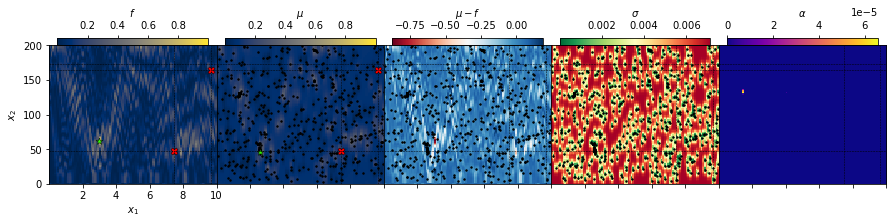

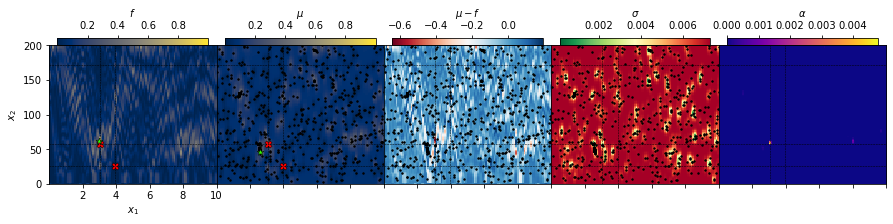

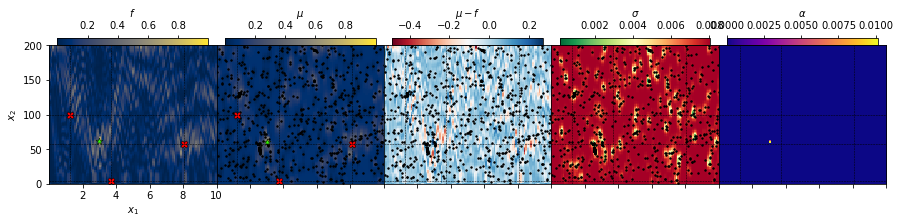

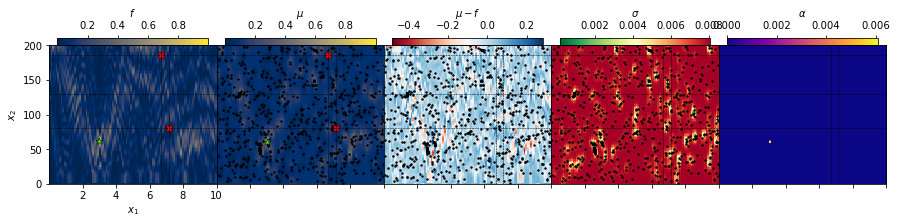

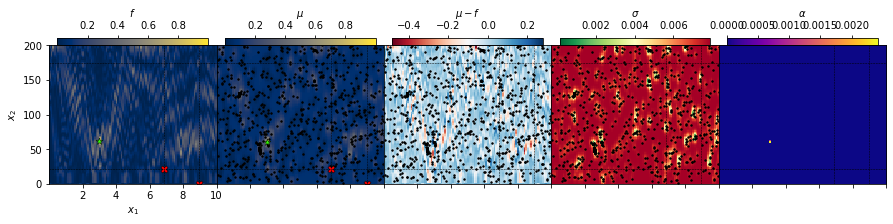

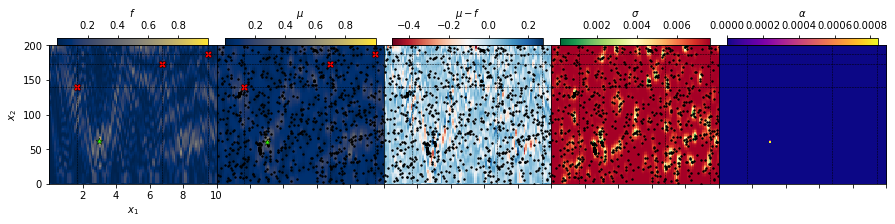

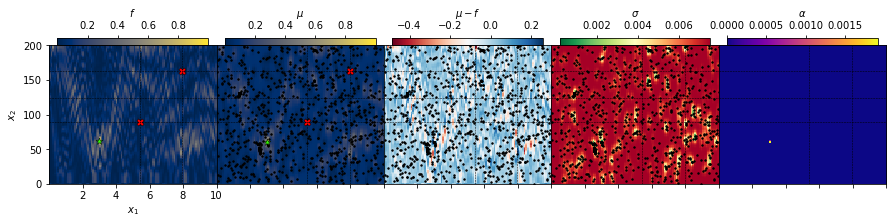

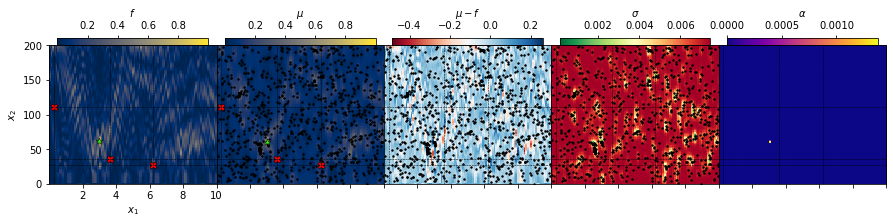

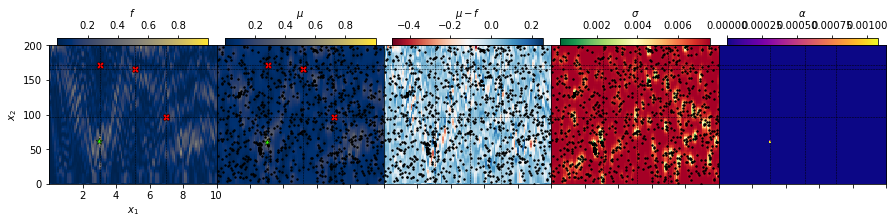

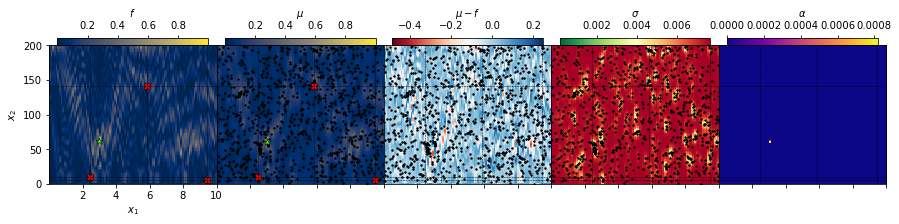

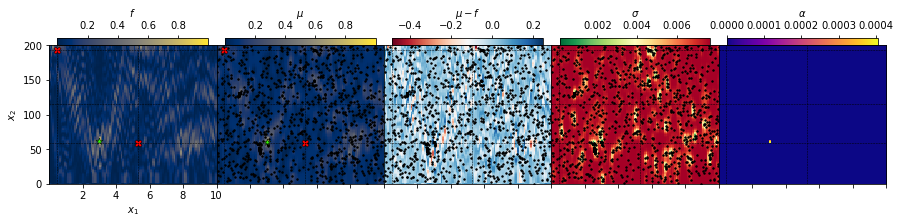

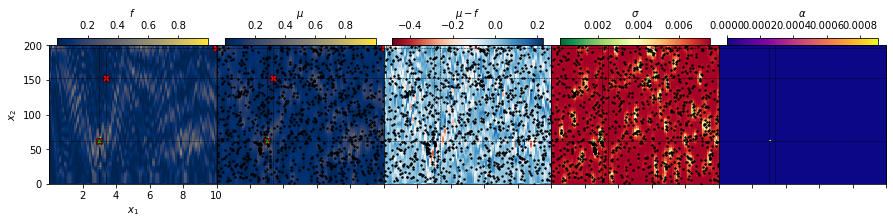

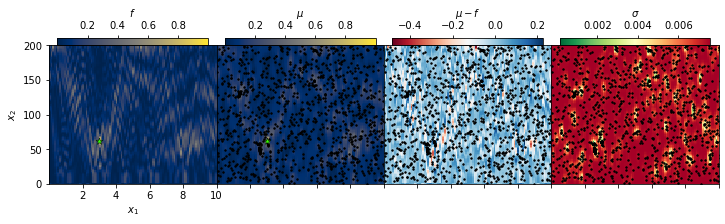

<AxesSubplot:>

: 

In [15]:
pltr = ResultsPlotter(optim_config, results)
parameters_to_plot = ["rec_r", "src_z"]
pltr.plot_training_iterations(X_test, parameters_to_plot, index=np.arange(0, 501, 20))